### Salary prediction, episode II: make it actually work (4 points)

Your main task is to use some of the tricks you've learned on the network and analyze if you can improve __validation MAE__. Try __at least 3 options__ from the list below for a passing grade. Write a short report about what you have tried. More ideas = more bonus points. 

__Please be serious:__ " plot learning curves in MAE/epoch, compare models based on optimal performance, test one change at a time. You know the drill :)

You can use either __pytorch__ or __tensorflow__ or any other framework (e.g. pure __keras__). Feel free to adapt the seminar code for your needs. For tensorflow version, consider `seminar_tf2.ipynb` as a starting point.


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [3]:
data = pd.read_csv("./Train_rev1.csv",index_col=None)
data.shape

(244768, 12)

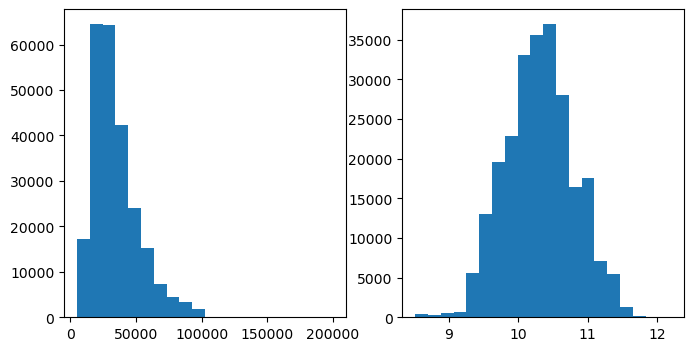

In [4]:
data['Log1pSalary'] = np.log1p(data['SalaryNormalized']).astype('float32')

plt.figure(figsize=[8, 4])
plt.subplot(1, 2, 1)
plt.hist(data["SalaryNormalized"], bins=20);

plt.subplot(1, 2, 2)
plt.hist(data['Log1pSalary'], bins=20);

In [5]:
text_columns = ["Title", "FullDescription"]
categorical_columns = ["Category", "Company", "LocationNormalized", "ContractType", "ContractTime"]
TARGET_COLUMN = "Log1pSalary"

data[categorical_columns] = data[categorical_columns].fillna('NaN') # cast missing values to string "NaN"

data.sample(3)

,Id,Title,FullDescription,LocationRaw,LocationNormalized,ContractType,ContractTime,Company,Category,SalaryRaw,SalaryNormalized,SourceName,Log1pSalary
230020,72450747,Database Coordinator,"Travelodge, Database Coordinator, Thame Oxford...",Thame Oxfordshire South East,Thame,NaN,permanent,360 Resourcing,Admin Jobs,15k per year,15000,totaljobs.com,9.615872
46855,68570450,Deputy Nursing Home Manager RGN or RMN,Deputy Nursing Home Manager RGN / RMN perman...,Worcestershire - Bewdley,Bewdley,full_time,permanent,UKStaffsearch,Healthcare & Nursing Jobs,28000 - 32000,30000,ukstaffsearch.com,10.308986
177355,71528398,Junior Sous Chef,Junior Sous Chef Fine Dining Pub **** Rosett...,North West,North West London,NaN,NaN,Platinum Recruitment Consultancy,Hospitality & Catering Jobs,17000 - 20000 per annum + Live In,18500,caterer.com,9.825580


In [6]:
torch.cuda.is_available()

False

### A short report

Please tell us what you did and how did it work.

`<YOUR_TEXT_HERE>`, i guess...

### Getting ready

In [7]:
import nltk
tokenizer = nltk.tokenize.WordPunctTokenizer()

def func(string: str) -> str:
    string = str(string)
    return ' '.join(tokenizer.tokenize(string)).lower()

data['Title'] = data['Title'].apply(func)
data['FullDescription'] = data['FullDescription'].apply(func)

In [8]:
from collections import Counter
token_counts = Counter()

for title in data['Title'].values:
    for token in title.split():
        token_counts[token] += 1

for title in data['FullDescription'].values:
    for token in title.split():
        token_counts[token] += 1

In [9]:
min_count = 10

# tokens from token_counts keys that had at least min_count occurrences throughout the dataset
tokens = sorted(t for t, c in token_counts.items() if c >= min_count)#TODO<YOUR CODE HERE>

# Add a special tokens for unknown and empty words
UNK, PAD = "UNK", "PAD"
tokens = [UNK, PAD] + tokens

In [10]:
token_to_id = dict()

for first, second in enumerate(tokens):
    token_to_id[second] = first

In [11]:
UNK_IX, PAD_IX = map(token_to_id.get, [UNK, PAD])

def as_matrix(sequences, max_len=None):
    """ Convert a list of tokens into a matrix with padding """
    if isinstance(sequences[0], str):
        sequences = list(map(str.split, sequences))
        
    max_len = min(max(map(len, sequences)), max_len or float('inf'))
    
    matrix = np.full((len(sequences), max_len), np.int32(PAD_IX))
    for i,seq in enumerate(sequences):
        row_ix = [token_to_id.get(word, UNK_IX) for word in seq[:max_len]]
        matrix[i, :len(row_ix)] = row_ix
    
    return matrix

In [12]:
from sklearn.feature_extraction import DictVectorizer

# we only consider top-1k most frequent companies to minimize memory usage
top_companies, top_counts = zip(*Counter(data['Company']).most_common(1000))
recognized_companies = set(top_companies)
data["Company"] = data["Company"].apply(lambda comp: comp if comp in recognized_companies else "Other")

categorical_vectorizer = DictVectorizer(dtype=np.float32, sparse=False)
categorical_vectorizer.fit(data[categorical_columns].apply(dict, axis=1))

DictVectorizer(dtype=<class 'numpy.float32'>, sparse=False)

In [13]:
from sklearn.model_selection import train_test_split

data_train, data_val = train_test_split(data, test_size=0.2, random_state=42)
data_train.index = range(len(data_train))
data_val.index = range(len(data_val))

print("Train size = ", len(data_train))
print("Validation size = ", len(data_val))

Train size =  195814
Validation size =  48954


In [14]:
import torch
import torch.nn as nn
import torch.nn.functional as F


device = 'cuda' if torch.cuda.is_available() else 'cpu'


def to_tensors(batch, device):
    batch_tensors = dict()
    for key, arr in batch.items():
        if key in ["FullDescription", "Title"]:
            batch_tensors[key] = torch.tensor(arr, device=device, dtype=torch.int64)
        else:
            batch_tensors[key] = torch.tensor(arr, device=device)
    return batch_tensors


def make_batch(data, max_len=None, word_dropout=0, device=device):
    """
    Creates a keras-friendly dict from the batch data.
    :param word_dropout: replaces token index with UNK_IX with this probability
    :returns: a dict with {'title' : int64[batch, title_max_len]
    """
    batch = {}
    batch["Title"] = as_matrix(data["Title"].values, max_len)
    batch["FullDescription"] = as_matrix(data["FullDescription"].values, max_len)
    batch['Categorical'] = categorical_vectorizer.transform(data[categorical_columns].apply(dict, axis=1))
    
    if word_dropout != 0:
        batch["FullDescription"] = apply_word_dropout(batch["FullDescription"], 1. - word_dropout)
    
    if TARGET_COLUMN in data.columns:
        batch[TARGET_COLUMN] = data[TARGET_COLUMN].values
    
    return to_tensors(batch, device)

def apply_word_dropout(matrix, keep_prop, replace_with=UNK_IX, pad_ix=PAD_IX,):
    dropout_mask = np.random.choice(2, np.shape(matrix), p=[keep_prop, 1 - keep_prop])
    dropout_mask &= matrix != pad_ix
    return np.choose(dropout_mask, [matrix, np.full_like(matrix, replace_with)])

### Model 

In [16]:
import gensim.downloader
word_embeddings = gensim.downloader.load("word2vec-google-news-300")
# Load pre-trained word embeddings (e.g., Word2Vec)

[==================================================] 100.0% 1662.8/1662.8MB downloaded


In [17]:
class SalaryPredictor(nn.Module):
    def __init__(self, embedding_dim=300, n_cat_features=len(categorical_vectorizer.vocabulary_)):
        super().__init__()

        # Shared Word Embeddings
        self.emb_shared = nn.Embedding.from_pretrained(torch.FloatTensor(word_embeddings.vectors), padding_idx=0)

        # Title
        self.title_conv = nn.Conv1d(in_channels=embedding_dim, out_channels=128, kernel_size=3, padding=1)
        self.title_relu = nn.ReLU()
        self.title_pooling = nn.AdaptiveMaxPool1d(1)
        self.title_dropout = nn.Dropout(p=0.5)

        # Description
        self.descr_conv = nn.Conv1d(in_channels=embedding_dim, out_channels=128, kernel_size=3, padding=1)
        self.descr_relu = nn.ReLU()
        self.descr_pooling = nn.AdaptiveMaxPool1d(1)
        self.descr_dropout = nn.Dropout(p=0.5)

        # Categorical features
        self.cat_features_encoder = nn.Sequential(
            nn.Linear(n_cat_features, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Linear(512, 128),
            nn.BatchNorm1d(128),
            nn.Dropout(p=0.5)
        )

        # Common network
        self.common_network = nn.Sequential(
            nn.Linear(2 + 128, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(64, 32),
            nn.BatchNorm1d(32),
            nn.ReLU(),
            nn.Linear(32, 1)
        )

    def forward(self, batch):
        title_data = batch['Title']
        description_data = batch['FullDescription']
        cat_features_data = batch['Categorical']

        # Shared Word Embeddings
        emb_shared_title = self.emb_shared(title_data)
        emb_shared_descr = self.emb_shared(description_data)

        # Title
        title_conv = self.title_conv(emb_shared_title.transpose(2, 1))
        title_relu = self.title_relu(title_conv)
        title_pooled = torch.max(title_relu, dim=-1).values
        title_pooled = self.title_dropout(title_pooled)
        title_pooled = self.title_pooling(title_pooled)

        # Description
        descr_conv = self.descr_conv(emb_shared_descr.transpose(2, 1))
        descr_relu = self.descr_relu(descr_conv)
        descr_pooled = torch.max(descr_relu, dim=-1).values
        descr_pooled = self.descr_dropout(descr_pooled)
        descr_pooled = self.descr_pooling(descr_pooled)

        # Categorical features
        cat_features_encoded = self.cat_features_encoder(cat_features_data)

        # Concatenate and pass through the common network
        combined_features = torch.cat([title_pooled, descr_pooled, cat_features_encoded], dim=1)
        predicted_salary = self.common_network(combined_features)

        return predicted_salary.squeeze()


In [18]:
model = SalaryPredictor()
model = SalaryPredictor().to(device)
batch = make_batch(data_train[:100], device=device)
criterion = nn.MSELoss()

In [19]:
dummy_pred = model(batch)
dummy_loss = criterion(dummy_pred, batch[TARGET_COLUMN])
print(dummy_pred)
print(dummy_pred.shape)
assert dummy_pred.shape == torch.Size([100])
assert len(torch.unique(dummy_pred)) > 20, "model returns suspiciously few unique outputs. Check your initialization"
assert dummy_loss.ndim == 0 and 0. <= dummy_loss <= 250., "make sure you minimize MSE"

tensor([ 0.1474, -0.4269,  0.3165, -0.4344, -0.1292,  0.1329, -0.0988,  0.3474,
         0.1000, -0.3508,  0.1084,  0.5270,  0.1537,  0.3537, -0.4094,  0.2254,
         0.4776, -0.3122,  0.4421, -0.0690, -0.8605, -0.1492,  0.3964, -0.1865,
        -0.2612, -0.6227, -0.6536,  0.2747, -0.4292,  0.2620, -0.2218,  0.0882,
        -0.1417, -0.1848, -0.4746, -0.0026, -0.4085, -0.4418, -0.2446, -0.2377,
        -0.4531, -0.5507,  0.9627,  0.4769, -0.1280,  0.6502, -0.1306, -0.1224,
        -0.0167,  0.3710,  0.2930, -0.0558, -0.0517,  0.3979, -0.3079, -0.2211,
         0.2037,  0.0222,  0.0937, -0.2284, -0.0462,  0.3929, -0.2048, -0.5232,
         0.2093,  0.1201,  0.0302, -0.1363, -0.1575,  0.0841, -0.8561,  0.7229,
         0.5787, -0.4132,  0.6076, -0.1725,  0.1938,  0.0597, -0.5880, -0.0139,
         0.4023, -0.4129,  0.0949,  0.2000, -0.7902,  0.1194,  0.1541, -0.5470,
         0.1960,  0.1433,  0.8777,  0.1447,  0.0539, -0.3496, -0.9201, -0.6731,
         0.0874, -0.2530,  0.0544, -0.42

In [20]:
def iterate_minibatches(data, batch_size=256, shuffle=True, cycle=False, device=device, **kwargs):
    """ iterates minibatches of data in random order """
    while True:
        indices = np.arange(len(data))
        if shuffle:
            indices = np.random.permutation(indices)

        for start in range(0, len(indices), batch_size):
            batch = make_batch(data.iloc[indices[start : start + batch_size]], device=device, **kwargs)
            yield batch
        
        if not cycle: break

### Training

In [21]:
from tqdm.auto import tqdm

BATCH_SIZE = 32
EPOCHS = 10

In [22]:
def print_metrics(model, data, batch_size=BATCH_SIZE, name="", device=torch.device('cpu'), **kw):
    squared_error = abs_error = num_samples = 0.0
    model.eval()
    with torch.no_grad():
        for batch in iterate_minibatches(data, batch_size=batch_size, shuffle=False, device=device, **kw):
            batch_pred = model(batch)
            squared_error += torch.sum(torch.square(batch_pred - batch[TARGET_COLUMN]))
            abs_error += torch.sum(torch.abs(batch_pred - batch[TARGET_COLUMN]))
            num_samples += len(batch_pred)
    mse = squared_error.detach().cpu().numpy() / num_samples
    mae = abs_error.detach().cpu().numpy() / num_samples
    print("%s results:" % (name or ""))
    print("Mean square error: %.5f" % mse)
    print("Mean absolute error: %.5f" % mae)
    return mse, mae


In [23]:
model = SalaryPredictor().to(device)
criterion = nn.MSELoss(reduction='sum')
optimizer = torch.optim.SGD(model.parameters(), lr=1e-4)

for epoch in range(EPOCHS):
    print(f"------------epoch: {epoch}")
    model.train()
    for i, batch in tqdm(enumerate(
            iterate_minibatches(data_train, batch_size=BATCH_SIZE, device=device)),
            total=len(data_train) // BATCH_SIZE
        ):
        pred = model(batch)
        loss = criterion(pred, batch[TARGET_COLUMN])
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    print_metrics(model, data_val, device=device)   

------------epoch: 0


  0%|          | 0/6119 [00:00<?, ?it/s]

 results:
Mean square error: 0.49953
Mean absolute error: 0.59896
------------epoch: 1


  0%|          | 0/6119 [00:00<?, ?it/s]

 results:
Mean square error: 0.30924
Mean absolute error: 0.45343
------------epoch: 2


  0%|          | 0/6119 [00:00<?, ?it/s]

 results:
Mean square error: 0.24207
Mean absolute error: 0.39203
------------epoch: 3


  0%|          | 0/6119 [00:00<?, ?it/s]

 results:
Mean square error: 0.20249
Mean absolute error: 0.35632
------------epoch: 4


  0%|          | 0/6119 [00:00<?, ?it/s]

 results:
Mean square error: 0.17473
Mean absolute error: 0.32824
------------epoch: 5


  0%|          | 0/6119 [00:00<?, ?it/s]

 results:
Mean square error: 0.14989
Mean absolute error: 0.30083
------------epoch: 6


  0%|          | 0/6119 [00:00<?, ?it/s]

 results:
Mean square error: 0.15141
Mean absolute error: 0.30318
------------epoch: 7


  0%|          | 0/6119 [00:00<?, ?it/s]

 results:
Mean square error: 0.14534
Mean absolute error: 0.29590
------------epoch: 8


  0%|          | 0/6119 [00:00<?, ?it/s]

 results:
Mean square error: 0.13996
Mean absolute error: 0.28970
------------epoch: 9


  0%|          | 0/6119 [00:00<?, ?it/s]

 results:
Mean square error: 0.14329
Mean absolute error: 0.29334


## Recommended options

#### A) CNN architecture

All the tricks you know about dense and convolutional neural networks apply here as well.
* Dropout. Nuff said.
* Batch Norm. This time it's `nn.BatchNorm*`/`L.BatchNormalization`
* Parallel convolution layers. The idea is that you apply several nn.Conv1d to the same embeddings and concatenate output channels.
* More layers, more neurons, ya know...


#### B) Play with pooling

There's more than one way to perform pooling:
* Max over time (independently for each feature)
* Average over time (excluding PAD)
* Softmax-pooling:
$$ out_{i, t} = \sum_t {h_{i,t} \cdot {{e ^ {h_{i, t}}} \over \sum_\tau e ^ {h_{j, \tau}} } }$$

* Attentive pooling
$$ out_{i, t} = \sum_t {h_{i,t} \cdot Attn(h_t)}$$

, where $$ Attn(h_t) = {{e ^ {NN_{attn}(h_t)}} \over \sum_\tau e ^ {NN_{attn}(h_\tau)}}  $$
and $NN_{attn}$ is a dense layer.

The optimal score is usually achieved by concatenating several different poolings, including several attentive pooling with different $NN_{attn}$ (aka multi-headed attention).

The catch is that keras layers do not inlude those toys. You will have to [write your own keras layer](https://keras.io/layers/writing-your-own-keras-layers/). Or use pure tensorflow, it might even be easier :)

#### C) Fun with words

It's not always a good idea to train embeddings from scratch. Here's a few tricks:

* Use a pre-trained embeddings from `gensim.downloader.load`. See last lecture.
* Start with pre-trained embeddings, then fine-tune them with gradient descent. You may or may not download pre-trained embeddings from [here](http://nlp.stanford.edu/data/glove.6B.zip) and follow this [manual](https://keras.io/examples/nlp/pretrained_word_embeddings/) to initialize your Keras embedding layer with downloaded weights.
* Use the same embedding matrix in title and desc vectorizer


#### D) Going recurrent

We've already learned that recurrent networks can do cool stuff in sequence modelling. Turns out, they're not useless for classification as well. With some tricks of course..

* Like convolutional layers, LSTM should be pooled into a fixed-size vector with some of the poolings.
* Since you know all the text in advance, use bidirectional RNN
  * Run one LSTM from left to right
  * Run another in parallel from right to left 
  * Concatenate their output sequences along unit axis (dim=-1)

* It might be good idea to mix convolutions and recurrent layers differently for title and description


#### E) Optimizing seriously

* You don't necessarily need 100 epochs. Use early stopping. If you've never done this before, take a look at [early stopping callback(keras)](https://keras.io/callbacks/#earlystopping) or in [pytorch(lightning)](https://pytorch-lightning.readthedocs.io/en/latest/common/early_stopping.html).
  * In short, train until you notice that validation
  * Maintain the best-on-validation snapshot via `model.save(file_name)`
  * Plotting learning curves is usually a good idea
  
Good luck! And may the force be with you!